In [12]:
# All imports
from Imports import *
from Preprocessing import *
from Helper import *
%matplotlib inline
warnings.filterwarnings('ignore')

In [13]:
# Load dataset and device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Dada paths
TRAIN_FILE = '../2025-Quantathon-Tornado-Q-training_data-640-examples.xlsx'
TEST_FILE = '../2025-Quantum-Tornado-Q-test_data-200-examples.xlsx'

# Load training data
df_train = pd.read_excel(TRAIN_FILE)
# Load test data
df_test = pd.read_excel(TEST_FILE)
print(f"✓ Training data loaded: {df_train.shape[0]} rows, {df_train.shape[1]} columns")
print(f"✓ Test data loaded: {df_test.shape[0]} rows, {df_test.shape[1]} columns")

✓ Training data loaded: 640 rows, 10 columns
✓ Test data loaded: 200 rows, 10 columns


In [42]:
# Binary DN without Quantum Layer
class BinaryDNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Encodes features from dataset
        self.feature_encoder = nn.Sequential(
            nn.Linear(8, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(128, 2048),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )

        # Classifies based on encoded features
        self.classifier = nn.Sequential(
            nn.Linear(2048, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 4)
        )

    def forward(self, features):
        feats_encoded = self.feature_encoder(features)
        class_target = self.classifier(feats_encoded)

        return class_target  # Shape: (batch_size, 4)

In [43]:
# Define variable and dataset
batch_size = 64
lr = 1e-2

X_train, y_train, X_test, y_test, X_smote_test, y_smote_test = Preprocess(df_train, df_test, balance = 'smote', classes = 'multiclass')

# Split training data into train + validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(y_test[:])
print(y_train[:])

train_data = ClassificationDataset(X_train, y_train)
validation_data = ClassificationDataset(X_val, y_val)
test_data = ClassificationDataset(X_test, y_test)
smote_test_data = ClassificationDataset(X_smote_test, y_smote_test)


train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(validation_data, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, drop_last=True)
smote_test_loader = DataLoader(test_data, batch_size=64, shuffle=False, drop_last=True)

X_batch, y_batch = next(iter(train_loader))

print("Batch X dtype:", X_batch.dtype)
print("Batch y dtype:", y_batch.dtype)

print("Number of training samples:", len(train_data))
print("Number of validation samples:", len(validation_data))
print("Number of test samples:", len(test_data))


0      1
1      0
2      1
3      0
4      2
      ..
195    1
196    1
197    3
198    0
199    0
Name: ef_class, Length: 200, dtype: int64
680     1
895     2
333     1
510     0
139     1
       ..
189     0
12      0
88      0
1060    3
582     0
Name: ef_class, Length: 1062, dtype: int64
Batch X dtype: torch.float32
Batch y dtype: torch.float32
Number of training samples: 1062
Number of validation samples: 266
Number of test samples: 200


In [44]:
# Initialize model, optimizer, and scheduler
n_epochs = 1000

DNN = BinaryDNN().to(device)
optimizer = optim.Adam(DNN.parameters(), lr=lr, betas=(0.9, 0.999))
scheduler_G = CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=1e-4)

# Empty array to track losses
losses = []

In [45]:
# # Plot visual of DNN
# graph =  draw_graph(
#     DNN,
#     input_size=(1, 8),
#     expand_nested=True,
#     depth = 1,
#     graph_name="DNN Architecture",
#     mode = 'train',
#     show_shapes = True,
#     hide_inner_tensors=True,   # Hides intermediate shapes
#     roll=True,                  # More compact layer grouping
#     save_graph=False,           # Set to True if you want to save
#     # node_attr={"color": "lightblue", "style": "filled"},  # Node styling
#     # edge_attr={"color": "gray"},                          # Edge styling
#     graph_dir= "TB",                         # Layout: TB (top-bottom), LR (left-right)
# )

# # Show in notebook
# graph.visual_graph

In [46]:
## Load a previous model
load = False

if load:
    # load_path = "models/Binary_DNN_" # Path to load model
    
    # Load the checkpoint
    checkpoint = torch.load(load_path)
    
    # Restore model weights
    DNN.load_state_dict(checkpoint["DNN_state_dict"])
    
    # Optionally restore tracking data
    losses = checkpoint["losses"]
        
    print(f"Loaded model from {load_path}")

In [47]:
cross_entropy = nn.CrossEntropyLoss()
metric = lambda outputs, target: (torch.argmax(outputs, dim=1) == target).float().mean().item()
best_val_metric = 0
best_val_loss = 999

history = {'epoch': [], 'train_loss': [], 'train_metric': [], 'val_loss': [], 'val_metric': []}

for epoch in range(n_epochs):
    DNN.train()
    train_loss, train_metric = 0.0, 0.0

    for features, target in train_loader:
        features, target = features.to(device), target.to(device).long()  # targets shape: (batch_size,)

        optimizer.zero_grad()
        outputs = DNN(features)              # logits: (batch_size, num_classes)
        loss = cross_entropy(outputs, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_metric += metric(outputs, target)

    train_loss /= len(train_loader)
    train_metric /= len(train_loader)

    # Validation
    DNN.eval()
    val_loss, val_metric = 0.0, 0.0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device).long()
            outputs = DNN(X_val)
            val_loss += cross_entropy(outputs, y_val).item()
            val_metric += metric(outputs, y_val)

    val_loss /= len(val_loader)
    val_metric /= len(val_loader)

    history['epoch'].append(epoch)
    history['train_loss'].append(train_loss)
    history['train_metric'].append(train_metric)
    history['val_loss'].append(val_loss)
    history['val_metric'].append(val_metric)

    if epoch % 100 == 99:
        print(f'Epoch [{epoch+1}/{n_epochs}] | Train Loss: {train_loss:.4f} | '
              f'Train Acc: {train_metric:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_metric:.4f}')

    # Save best model (accuracy)
    if val_metric > best_val_metric:
        best_val_metric = val_metric
        os.makedirs("models", exist_ok=True)
        save_path = "models/DNN_multiclass_best_accuracy.pt"
        torch.save({"DNN_state_dict": DNN.state_dict(), "history": history}, save_path)

    # Save best model (val loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        os.makedirs("models", exist_ok=True)
        save_path = "models/DNN_multiclass_best_valLoss.pt"
        torch.save({"DNN_state_dict": DNN.state_dict(), "history": history}, save_path)


Epoch [100/1000] | Train Loss: 0.9621 | Train Acc: 0.6025 | Val Loss: 0.8726 | Val Acc: 0.6289
Epoch [200/1000] | Train Loss: 0.8949 | Train Acc: 0.6133 | Val Loss: 0.8039 | Val Acc: 0.6562
Epoch [300/1000] | Train Loss: 0.8243 | Train Acc: 0.6396 | Val Loss: 0.8918 | Val Acc: 0.6133
Epoch [400/1000] | Train Loss: 0.8046 | Train Acc: 0.6738 | Val Loss: 0.8950 | Val Acc: 0.6289
Epoch [500/1000] | Train Loss: 0.8682 | Train Acc: 0.6367 | Val Loss: 0.8197 | Val Acc: 0.6211
Epoch [600/1000] | Train Loss: 0.7798 | Train Acc: 0.6865 | Val Loss: 0.7181 | Val Acc: 0.6875
Epoch [700/1000] | Train Loss: 0.9352 | Train Acc: 0.5869 | Val Loss: 0.7283 | Val Acc: 0.6914
Epoch [800/1000] | Train Loss: 0.7667 | Train Acc: 0.6973 | Val Loss: 0.8918 | Val Acc: 0.6523
Epoch [900/1000] | Train Loss: 0.6829 | Train Acc: 0.7129 | Val Loss: 0.7714 | Val Acc: 0.6641
Epoch [1000/1000] | Train Loss: 0.7481 | Train Acc: 0.7188 | Val Loss: 0.6468 | Val Acc: 0.7266


In [51]:
## Save Model
# Create output directory if it doesn't exist

save = True
if save:
    os.makedirs("models", exist_ok=True)
    
    # Timestamp for unique filenames
    timestamp = datetime.now().strftime("%m%d_%H%M")
    
    # Save model states and tracked data in a single file
    save_path = f"models/Multiclass_DNN_{timestamp}.pt"
    torch.save({
        "DNN_state_dict": DNN.state_dict(),
        "losses": losses,
    }, save_path)
    
    print(f"Model and statistics saved to {save_path}")

Model and statistics saved to models/Multiclass_DNN_best_so_far_1010_2334.pt


AUC: 0.5734, F1: 0.3278, Accuracy: 0.5104
Class 0 CSI: 0.5426
Class 1 CSI: 0.2418
Class 2 CSI: 0.1224
Class 3 CSI: 0.0000


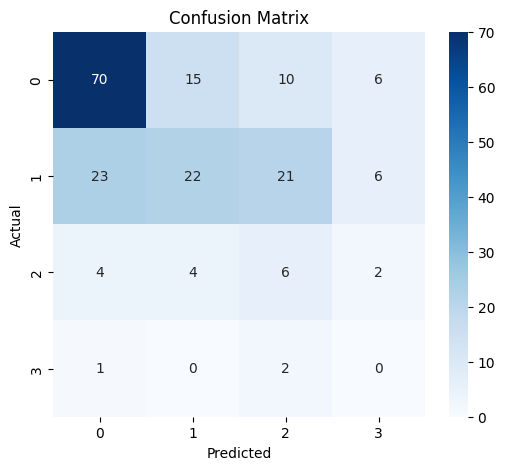

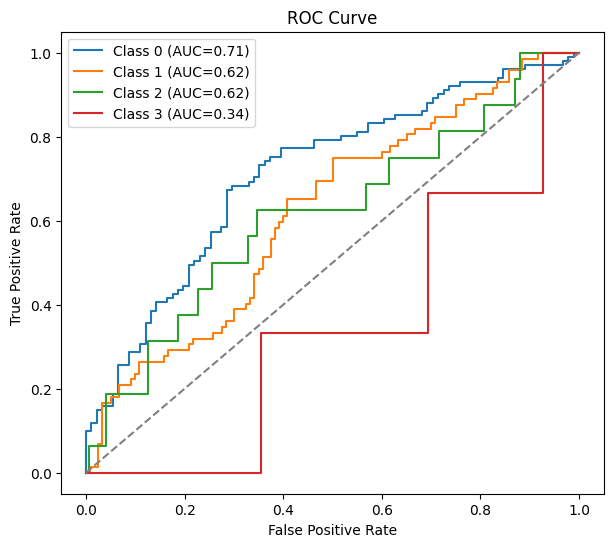

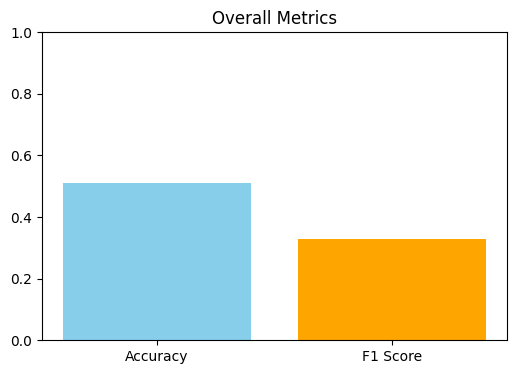

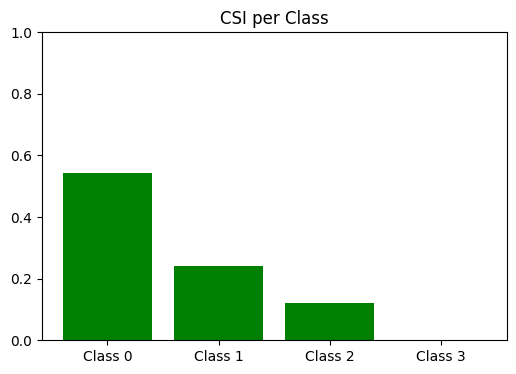

In [49]:
DNN.eval()
all_targets, all_preds, all_probs = [], [], []

with torch.no_grad():
    for features, target in test_loader:
        features = features.to(device)
        target = target.to(device).long()
        outputs = DNN(features)
        
        if outputs.shape[1] == 1:
            # Binary case
            probs = torch.sigmoid(outputs).squeeze(-1)
            preds = (probs > 0.5).long()
        else:
            # Multiclass case
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

        all_targets.append(target.cpu())
        all_preds.append(preds.cpu())
        all_probs.append(probs.cpu())

# Concatenate
all_targets = torch.cat(all_targets).numpy()
all_preds = torch.cat(all_preds).numpy()
all_probs = torch.cat(all_probs).numpy()

# Metrics
cm = confusion_matrix(all_targets, all_preds)
acc = accuracy_score(all_targets, all_preds)
if outputs.shape[1] == 1:
    f1 = f1_score(all_targets, all_preds)
    auc_score = roc_auc_score(all_targets, all_probs)
    csi = cm[1,1] / (cm[1,1] + cm[1,0] + cm[0,1])
else:
    num_classes = outputs.shape[1]
    f1 = f1_score(all_targets, all_preds, average='macro')
    auc_score = roc_auc_score(np.eye(num_classes)[all_targets], all_probs, multi_class='ovr')
    csi = []
    for i in range(num_classes):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        csi.append(tp / (tp + fn + fp) if (tp+fn+fp)>0 else 0)

# Print metrics
print(f"AUC: {auc_score:.4f}, F1: {f1:.4f}, Accuracy: {acc:.4f}")
if outputs.shape[1] > 1:
    for i, c in enumerate(csi):
        print(f"Class {i} CSI: {c:.4f}")
else:
    print(f"CSI: {csi:.4f}")

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
plt.figure(figsize=(7,6))
if outputs.shape[1] == 1:
    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    plt.plot(fpr, tpr, label=f'AUC={auc_score:.4f}')
else:
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve((all_targets==i).astype(int), all_probs[:,i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Overall metrics bar
metrics = {'Accuracy': acc, 'F1 Score': f1}
plt.figure(figsize=(6,4))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue','orange'])
plt.ylim(0,1)
plt.title('Overall Metrics')
plt.show()

# CSI bar for multiclass
if outputs.shape[1] > 1:
    plt.figure(figsize=(6,4))
    plt.bar([f'Class {i}' for i in range(num_classes)], csi, color='green')
    plt.ylim(0,1)
    plt.title('CSI per Class')
    plt.show()


AUC: 0.5734, F1: 0.3278, Accuracy: 0.5104
Class 0 CSI: 0.5426
Class 1 CSI: 0.2418
Class 2 CSI: 0.1224
Class 3 CSI: 0.0000


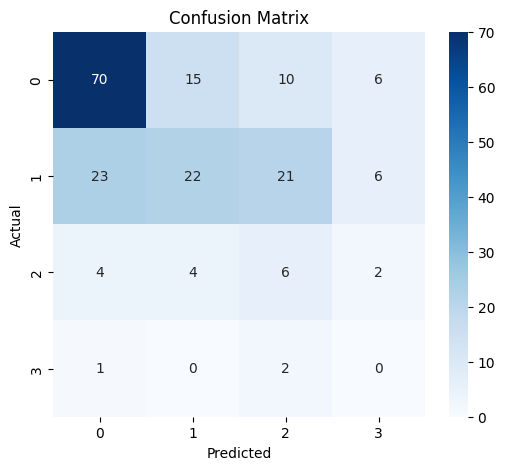

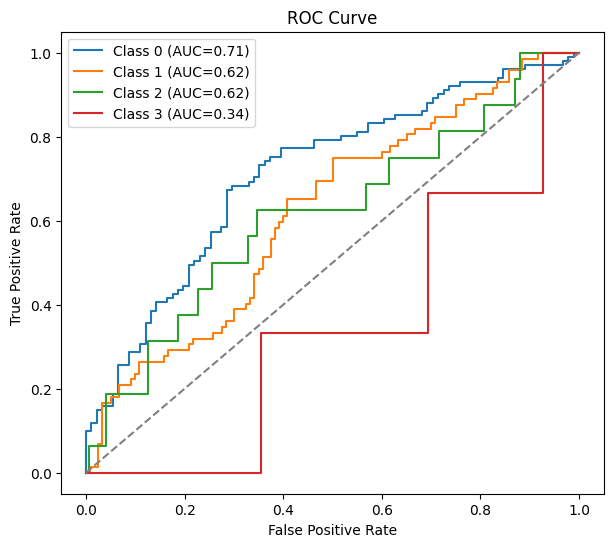

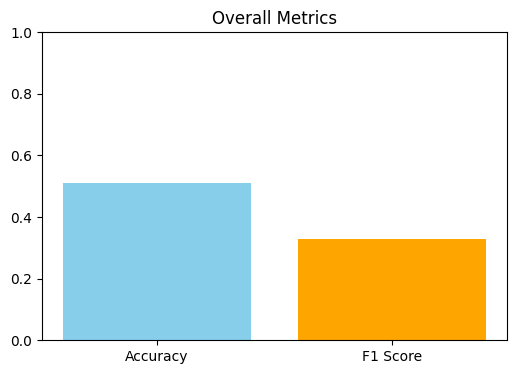

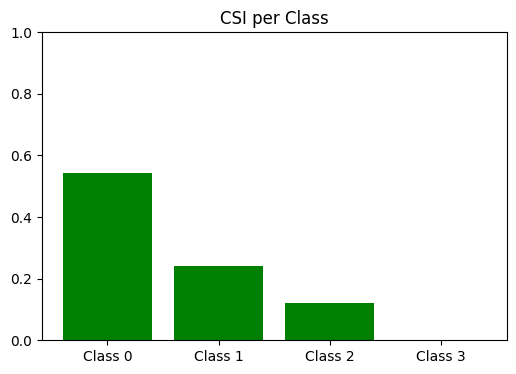

In [50]:
DNN.eval()
all_targets, all_preds, all_probs = [], [], []

with torch.no_grad():
    for features, target in smote_test_loader:
        features = features.to(device)
        target = target.to(device).long()
        outputs = DNN(features)
        
        if outputs.shape[1] == 1:
            # Binary case
            probs = torch.sigmoid(outputs).squeeze(-1)
            preds = (probs > 0.5).long()
        else:
            # Multiclass case
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

        all_targets.append(target.cpu())
        all_preds.append(preds.cpu())
        all_probs.append(probs.cpu())

# Concatenate
all_targets = torch.cat(all_targets).numpy()
all_preds = torch.cat(all_preds).numpy()
all_probs = torch.cat(all_probs).numpy()

# Metrics
cm = confusion_matrix(all_targets, all_preds)
acc = accuracy_score(all_targets, all_preds)
if outputs.shape[1] == 1:
    f1 = f1_score(all_targets, all_preds)
    auc_score = roc_auc_score(all_targets, all_probs)
    csi = cm[1,1] / (cm[1,1] + cm[1,0] + cm[0,1])
else:
    num_classes = outputs.shape[1]
    f1 = f1_score(all_targets, all_preds, average='macro')
    auc_score = roc_auc_score(np.eye(num_classes)[all_targets], all_probs, multi_class='ovr')
    csi = []
    for i in range(num_classes):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        csi.append(tp / (tp + fn + fp) if (tp+fn+fp)>0 else 0)

# Print metrics
print(f"AUC: {auc_score:.4f}, F1: {f1:.4f}, Accuracy: {acc:.4f}")
if outputs.shape[1] > 1:
    for i, c in enumerate(csi):
        print(f"Class {i} CSI: {c:.4f}")
else:
    print(f"CSI: {csi:.4f}")

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
plt.figure(figsize=(7,6))
if outputs.shape[1] == 1:
    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    plt.plot(fpr, tpr, label=f'AUC={auc_score:.4f}')
else:
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve((all_targets==i).astype(int), all_probs[:,i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Overall metrics bar
metrics = {'Accuracy': acc, 'F1 Score': f1}
plt.figure(figsize=(6,4))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue','orange'])
plt.ylim(0,1)
plt.title('Overall Metrics')
plt.show()

# CSI bar for multiclass
if outputs.shape[1] > 1:
    plt.figure(figsize=(6,4))
    plt.bar([f'Class {i}' for i in range(num_classes)], csi, color='green')
    plt.ylim(0,1)
    plt.title('CSI per Class')
    plt.show()
